In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.neighbors import KernelDensity

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

from scipy.optimize import minimize
from scipy.integrate import quad
from scipy.stats import gaussian_kde
from astroML.datasets import generate_mu_z  


from astropy.cosmology import LambdaCDM
import scipy.stats as scistats
import emcee, corner
import dynesty
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc

rng = np.random.default_rng(42)

plt.rcParams["figure.figsize"] = (7, 5)
plt.rcParams["axes.grid"] = True
plt.rcParams["font.size"] = 12

In [2]:
#Extract the data and put into a dataframe
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234)  

df = pd.DataFrame({"z": z_sample, "mu": mu_sample, "sigma_mu": dmu}).sort_values("z").reset_index(drop=True)
df.head()

,z,mu,sigma_mu
0,0.073465,36.846956,0.851581
1,0.075711,38.680323,0.852958
2,0.098009,38.489351,0.864852
3,0.153286,40.017135,0.885883
4,0.158993,39.997579,0.887629


# Part 2 


# GAUSSIAN PROCESS REGRESSION

Best length_scale from CV: 0.31622776601683794


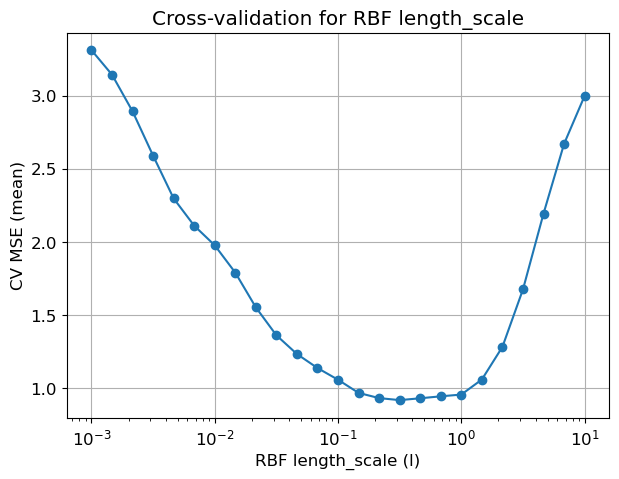

In [12]:
z = df["z"].to_numpy().reshape(-1,1)
mu = df["mu"].to_numpy()
alpha = df["sigma_mu"].to_numpy()**2  # heteroskedastic noise 

# Cross-validation over length_scale grid
length_grid = np.logspace(-3, 1, 25)  # l in [1e-3, 10] (log-spaced)
kf = KFold(n_splits=5, shuffle=True, random_state=123)

cv_results = []
for ell in length_grid:
    mse_folds = []
    for train_idx, val_idx in kf.split(z):
        z_tr, z_val = z[train_idx], z[val_idx]
        y_tr, y_val = mu[train_idx], mu[val_idx]
        a_tr, a_val = alpha[train_idx], alpha[val_idx]
        
        # # RBF (Radial Basis Function) kernel (k(z, z') = exp( - (z - z')^2 / (2 * l^2) )):
        # - If l is small, the GP can follow very rapid variations -> risk of overfitting.
        # - If l is large, the GP becomes overly smooth -> risk of underfitting.
        gpr_cv = GaussianProcessRegressor(kernel=RBF(length_scale=ell, length_scale_bounds="fixed"), 
                                          alpha=a_tr, normalize_y=True, optimizer=None)  
        gpr_cv.fit(z_tr, y_tr)
        y_pred = gpr_cv.predict(z_val)
        mse_folds.append(mean_squared_error(y_val, y_pred, sample_weight=1.0/a_val))
    cv_results.append((ell, np.mean(mse_folds)))

cv_df = pd.DataFrame(cv_results, columns=["length_scale", "mse_mean"])
best_row = cv_df.iloc[cv_df["mse_mean"].argmin()]
best_ell = float(best_row["length_scale"])
print("Best length_scale from CV:", best_ell)

# Plot CV curve
fig, ax = plt.subplots()
ax.semilogx(cv_df["length_scale"], cv_df["mse_mean"], marker="o")
ax.set_xlabel("RBF length_scale (l)")
ax.set_ylabel("CV MSE (mean)")
ax.set_title("Cross-validation for RBF length_scale")
plt.show()




Final kernel: RBF(length_scale=0.316)


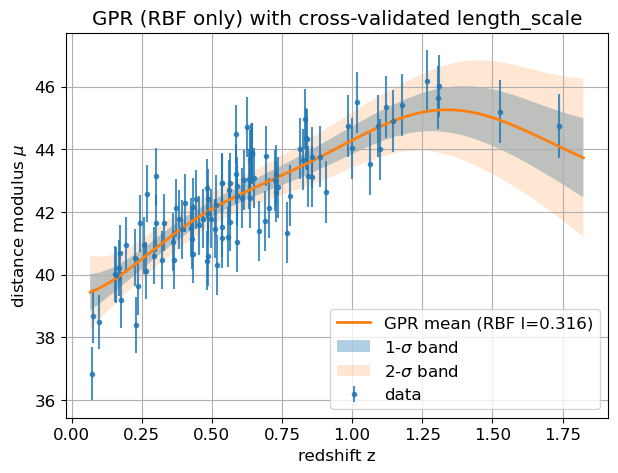

In [4]:
# Fit final GP with best length scale 
gpr = GaussianProcessRegressor(kernel=RBF(length_scale=best_ell, length_scale_bounds="fixed"),
                               alpha=alpha, normalize_y=True, optimizer=None)
gpr.fit(z, mu)
print("Final kernel:", gpr.kernel_)
z_grid = np.linspace(df["z"].min()*0.9, df["z"].max()*1.05, 500).reshape(-1,1)
mu_pred, mu_std = gpr.predict(z_grid, return_std=True)

#Plot the fit
plt.figure()
plt.errorbar(df["z"], df["mu"], yerr=df["sigma_mu"], fmt=".", alpha=0.8, label="data")
plt.plot(z_grid.ravel(), mu_pred, lw=2, label=f"GPR mean (RBF l={best_ell:.3g})")
plt.fill_between(z_grid.ravel(), mu_pred-mu_std, mu_pred+mu_std, alpha=0.35, label="1-$\sigma$ band")
plt.fill_between(z_grid.ravel(), mu_pred-2*mu_std, mu_pred+2*mu_std, alpha=0.18, label="2-$\sigma$ band")
plt.xlabel("redshift z")
plt.ylabel("distance modulus $\mu$")
plt.title("GPR (RBF only) with cross-validated length_scale")
plt.legend()
plt.show()

## Clone the dataset ×10 using empirical \(p(z)\) and the GP predictive distribution

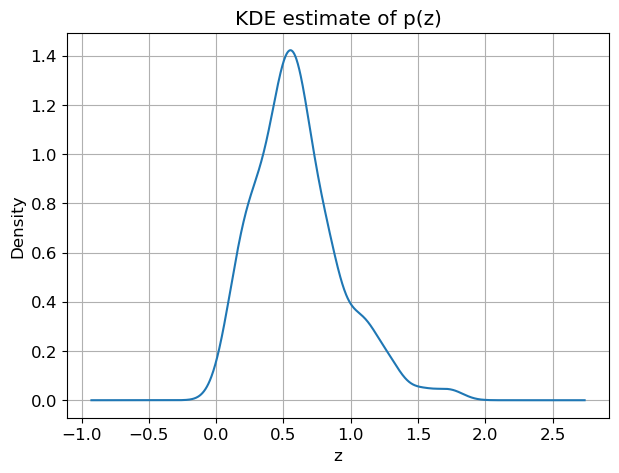

In [5]:
# Fit a Gaussian KDE to the observed redshifts 
z_vals = df["z"].to_numpy().reshape(-1, 1)
kde = KernelDensity(kernel="gaussian", bandwidth=0.1).fit(z_vals)  

# Visualize the estimated density 
z_plot = np.linspace(z_vals.min() - 1.0, z_vals.max() + 1.0, 1000).reshape(-1, 1)
log_dens = kde.score_samples(z_plot)   
dens = np.exp(log_dens)                # convert to density

plt.plot(z_plot[:, 0], dens)
plt.xlabel("z")
plt.ylabel("Density")
plt.title("KDE estimate of p(z)")
plt.show()


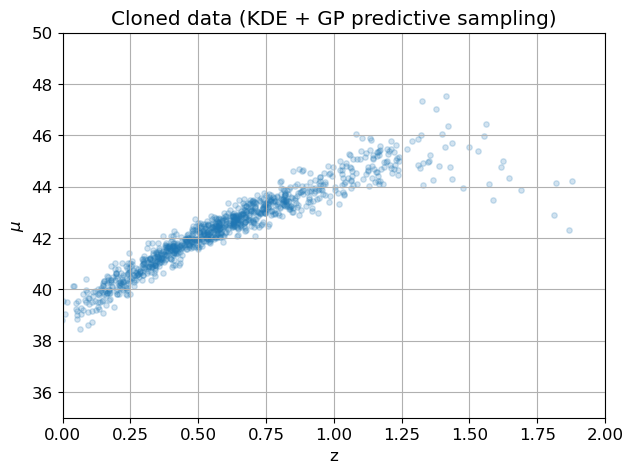

In [6]:

# Sample new redshifts directly from the KDE 
N = 1000  # number of cloned redshifts 
new_z_samples = kde.sample(N, random_state=42)  # shape (N, 1)

# Use the GP predictive distribution to generate mu at those z
# Draw from N(mu_GP, sigma_GP) for each sampled redshift.
mu_mean, mu_std = gpr.predict(new_z_samples, return_std=True)   
mu_gpr = np.random.normal(loc=mu_mean, scale=mu_std)            # one draw per point

# Plot the cloned points
plt.scatter(new_z_samples[:, 0], mu_gpr, alpha=0.2, s=15)
plt.xlabel("z")
plt.ylabel(r"$\mu$")
plt.xlim(0, 2)
plt.ylim(35, 50)
plt.title("Cloned data (KDE + GP predictive sampling)")
plt.show()


# Part 3  

# ΛCDM parametric fit

In [7]:
# distance modulus mu(z) for flat lambdaCDM (two parameters: Ho and Om)
def generativemodel(z, H0, Om):
    cosmo_tmp = LambdaCDM(H0=H0, Om0=Om, Ode0=1-Om)
    return cosmo_tmp.distmod(z).value

#Likelihood
def loglike(theta):
    Om, H0 = theta
    if Om < 0 or Om > 1 or H0 <= 0:
        return -np.inf
    mu_model = generativemodel(z_sample, H0, Om)
    return np.sum(scistats.norm(loc=mu_model, scale=dmu).logpdf(mu_sample))

#Priors
def logprior(theta):
    Om, H0 = theta
    if (0.1 < Om < 1.0) and (50.0 < H0 < 100.0):
        return 0.0  # uniform prior in bounds
    return -np.inf

#Posterior
def logposterior(theta):
    lp = logprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    ll = loglike(theta)
    return lp + ll



# Maximum Likelihood Estimate (MLE) (to initialize walkers)

MLE: Ωm=0.345, H0=68.52   (success=True)


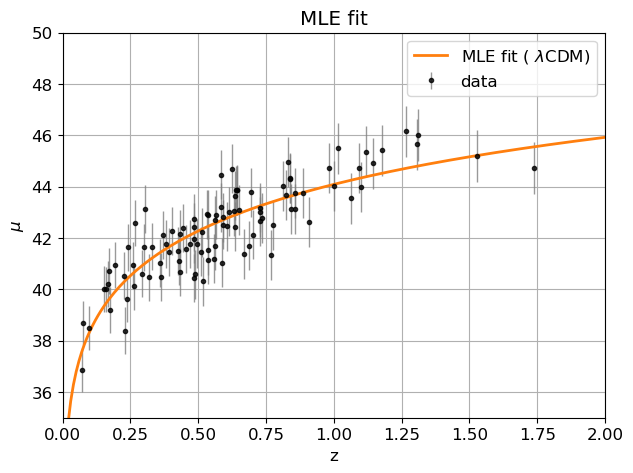

In [8]:
#Minimize the -loglikelihood 
def nll(theta):
    val = loglike(theta)
    return -val 

x0 = np.array([0.3, 70.0])  # (Ωm, H0) initial guess
res = minimize(lambda th: nll(th), x0=x0, method="Nelder-Mead",
               options=dict(maxiter=5000, xatol=1e-6, fatol=1e-6))
Om_mle, H0_mle = res.x
print(f"MLE: Ωm={Om_mle:.3f}, H0={H0_mle:.2f}   (success={res.success})")

# Plot MLE fit
z_lin = np.linspace(0, 2, 200)[1:]
mu_mle = generativemodel(z_lin, H0_mle, Om_mle)
plt.figure()
plt.errorbar(z_sample, mu_sample, yerr=dmu, fmt=".k", ecolor="gray", lw=1, alpha=0.8, label="data")
plt.plot(z_lin, mu_mle, c="C1", lw=2, label="MLE fit ( $\lambda$CDM)")
plt.xlabel("z"); plt.ylabel(r"$\mu$"); plt.xlim(0, 2); plt.ylim(35, 50)
plt.legend(); plt.title("MLE fit")
plt.show()

## MCMC with `emcee` (sample the posterior \(p(Omega_m, H_0 | data)\) using an ensemble sampler)


Chain shape (flattened): (5112, 2)
Burn-in, thin: 111 37


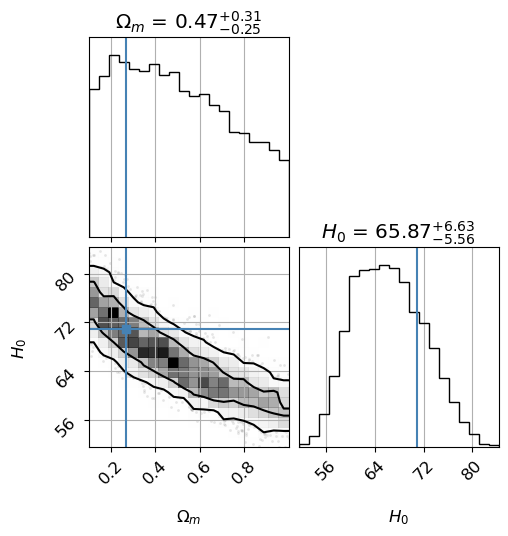

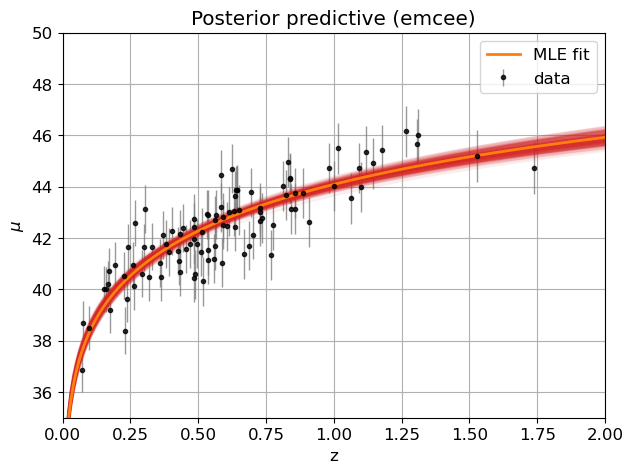

$\Omega_m$ (16-50-84): [0.2235259  0.47153729 0.78145493]
H0 (16-50-84): [60.30719237 65.87207316 72.49989994]


In [ ]:
ndim = 2
nwalkers = 24
nsteps = 8000

# Initialize walkers near MLE 
start_mean = np.array([Om_mle, H0_mle])
starting_guesses = start_mean + 1e-2 * rng.normal(size=(nwalkers, ndim)) #keeps diversity

sampler = emcee.EnsembleSampler(nwalkers, ndim, logposterior)
sampler.run_mcmc(starting_guesses, nsteps, progress=False)

# Autocorrelation-based burn/thin 
tau = sampler.get_autocorr_time()
burn = int(3*np.max(tau))
thin = int(np.max(tau))


flat_samples = sampler.get_chain(discard=burn, thin=thin, flat=True)
print("Chain shape (flattened):", flat_samples.shape)
print("Burn-in, thin:", burn, thin)

# Corner plot
fig = corner.corner(flat_samples, labels=[r"$\Omega_m$", r"$H_0$"],
                    levels=[0.68, 0.95], show_titles=True, truths=[0.27, 71])
plt.show()

# Posterior predictive
plt.figure()
plt.errorbar(z_sample, mu_sample, yerr=dmu, fmt=".k", ecolor="gray", lw=1, alpha=0.8, label="data")
for Om, H0 in flat_samples[::max(1, len(flat_samples)//200)]: #plot 200 equally spaced samples from the MCMC chain
    plt.plot(z_lin, generativemodel(z_lin, H0, Om), c="C3", alpha=0.08)
plt.plot(z_lin, mu_mle, c="C1", lw=2, label="MLE fit")
plt.xlabel("z"); plt.ylabel(r"$\mu$"); plt.xlim(0, 2); plt.ylim(35, 50)
plt.legend(); plt.title("Posterior predictive (emcee)")
plt.show()

# Posterior summary statistics
Om_q = np.percentile(flat_samples[:,0], [16, 50, 84])
H0_q = np.percentile(flat_samples[:,1], [16, 50, 84])
print(f"$\Omega_m$ (16-50-84): {Om_q}")
print(f"H0 (16-50-84): {H0_q}")

## Nested Sampling (provides also the evidence logZ for model comparison)

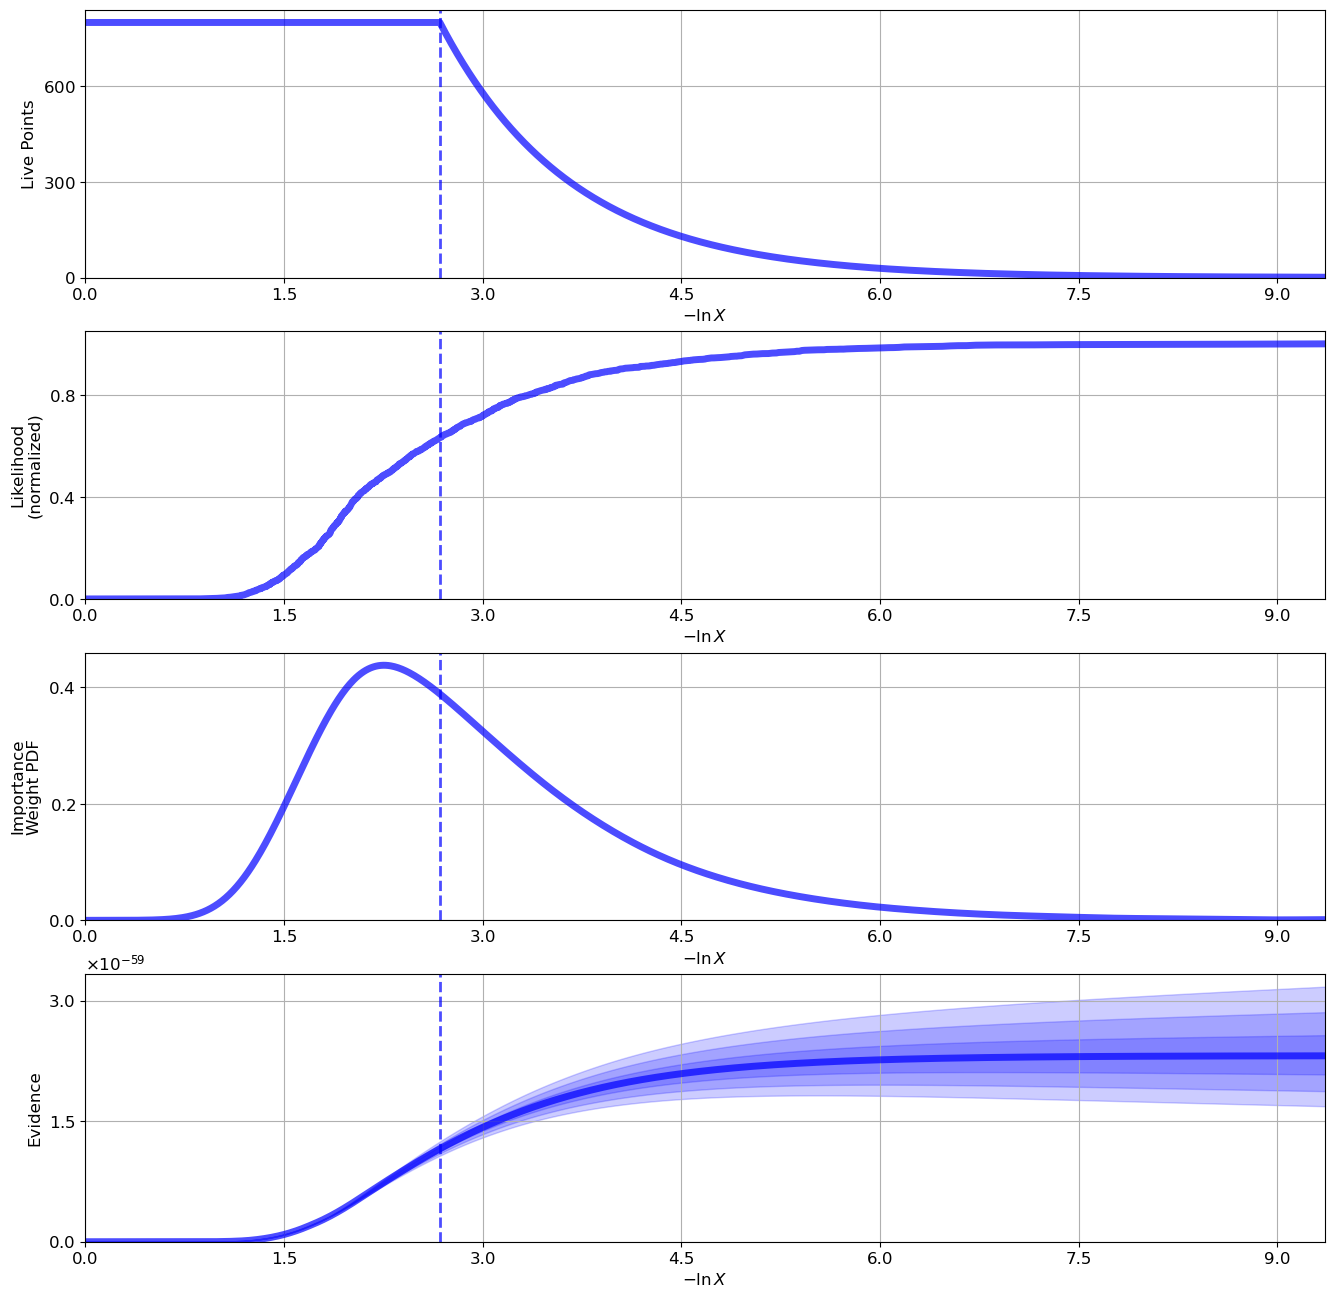

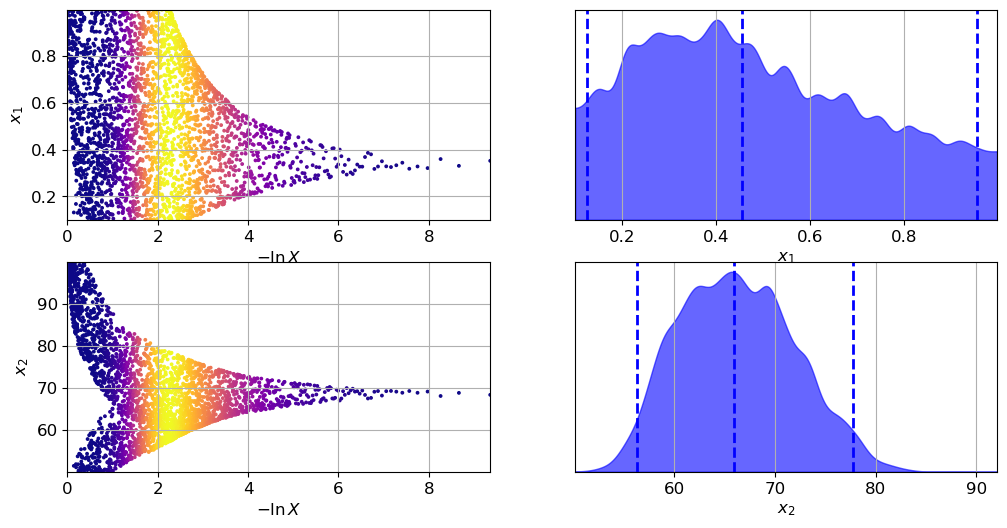

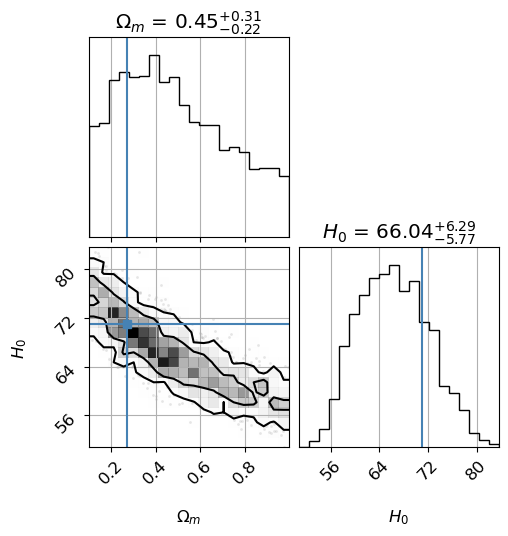

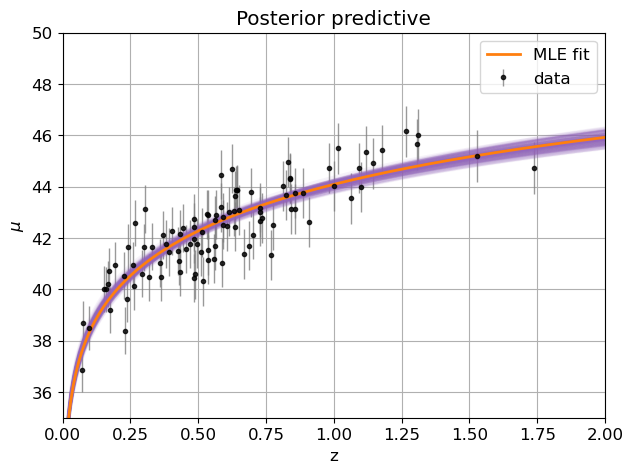

68% credible regions (nested): [[0.2364499530235809, 0.7625632005228153], [60.2388183046245, 72.22788045219625]]
logZ (ΛCDM, nested) = -135.014 ± 0.105


In [ ]:
ndims = 2

##Map unit cube u -> (omega_m, H0) with uniform priors on the same bounds.
def prior_transform(u):
    mins = np.array([0.1, 50.0])
    maxs = np.array([1.0, 100.0])
    return mins + u * (maxs - mins)

nest = dynesty.NestedSampler(loglike, prior_transform, ndims, nlive=800)
nest.run_nested(print_progress=False)
ns_results = nest.results

#Run plot and trace plot
rfig, raxes = dyplot.runplot(ns_results)
tfig, taxes = dyplot.traceplot(ns_results)
plt.show()

# Weighted posterior and equal-weight resampling
samples_ns = ns_results.samples
weights_ns = np.exp(ns_results.logwt - ns_results.logz[-1])
samples_equal = dyfunc.resample_equal(samples_ns, weights_ns)

# Corner
fig = corner.corner(samples_equal, labels=[r"$\Omega_m$", r"$H_0$"],
                    levels=[0.68, 0.95], show_titles=True, truths=[0.27, 71])
plt.show()

# Posterior predictive
plt.figure()
plt.errorbar(z_sample, mu_sample, yerr=dmu, fmt=".k", ecolor="gray", lw=1, alpha=0.8, label="data")
for Om, H0 in samples_equal[::max(1, len(samples_equal)//200)]:
    plt.plot(z_lin, generativemodel(z_lin, H0, Om), c="C4", alpha=0.08)
plt.plot(z_lin, mu_mle, c="C1", lw=2, label="MLE fit")
plt.xlabel("z"); plt.ylabel(r"$\mu$"); plt.xlim(0, 2); plt.ylim(35, 50)
plt.legend(); plt.title("Posterior predictive")
plt.show()

# Credible intervals and evidence
quantiles = [dyfunc.quantile(samps, [0.16, 0.84], weights=weights_ns)
             for samps in samples_ns.T]
print("68% credible regions (nested):", quantiles)

logZ = ns_results.logz[-1]
logZ_err = ns_results.logzerr[-1]
print(f"logZ (ΛCDM, nested) = {logZ:.3f} ± {logZ_err:.3f}")

## Model selection: ΛCDM vs no–dark-energy (omega_m=1)

In [11]:
# No–dark-energy model (omega_m fixed to 1): sample only H0
def loglike_noDE(theta):
    (H0,) = theta
    mu_model = generativemodel(z_sample, H0, 1.0)
    return np.sum(scistats.norm(loc=mu_model, scale=dmu).logpdf(mu_sample))

def prior_transform_noDE(u):
    H0_min, H0_max = 50.0, 100.0
    return np.array([H0_min + u[0]*(H0_max - H0_min)])

#Nasted sampling
nest_noDE = dynesty.NestedSampler(loglike_noDE, prior_transform_noDE, ndim=1, nlive=800)
nest_noDE.run_nested(print_progress=False)
res_noDE = nest_noDE.results
logZ_noDE, logZ_noDE_err = res_noDE.logz[-1], res_noDE.logzerr[-1]
Delta_logZ = (logZ - logZ_noDE)
samples_noDE = res_noDE.samples                    # shape (N, 1) for H0 only
weights_noDE = np.exp(res_noDE.logwt - res_noDE.logz[-1])  # normalized posterior weights
H0_equal_noDE = dyfunc.resample_equal(samples_noDE, weights_noDE).ravel()

# Weighted mean and 16-84% credible interval for H0 (no-DE)
H0_mean_noDE = np.average(samples_noDE.ravel(), weights=weights_noDE)
H0_ci_noDE = np.percentile(H0_equal_noDE, [16, 50, 84])
print(f"H0 (no-DE) weighted mean ≈ {H0_mean_noDE:.2f}   |   16-50-84% = {H0_ci_noDE}")

# Decide preferred model by evidence and interpret dlogZ with Jeffreys scale
def jeffreys_label(delta_logZ):
    d = abs(delta_logZ)
    if d < 1.0:
        return "inconclusive (barely worth mentioning)"
    elif d < 2.5:
        return "weak/substantial evidence"
    elif d < 5.0:
        return "moderate/strong evidence"
    else:
        return "decisive/very strong evidence"

preferred = "ΛCDM" if Delta_logZ > 0 else "no–dark-energy (Ωm=1)"
bayes_factor = np.exp(Delta_logZ)

print("Model comparison")
print(f"logZ(ΛCDM) = {logZ:.3f}   |   logZ(no-DE) = {logZ_noDE:.3f}")
print(f"ΔlogZ (ΛCDM − noDE) = {Delta_logZ:.3f}   → Bayes factor = {bayes_factor:.2f}")
print(f"Preferred model: {preferred}  |  Jeffreys scale: {jeffreys_label(Delta_logZ)}")


H0 (no-DE) weighted mean ≈ 57.87   |   16-50-84% = [55.33880429 57.78416659 60.48233174]
Model comparison
logZ(ΛCDM) = -135.014   |   logZ(no-DE) = -135.584
ΔlogZ (ΛCDM − noDE) = 0.570   → Bayes factor = 1.77
Preferred model: ΛCDM  |  Jeffreys scale: inconclusive (barely worth mentioning)
